In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from apyori import apriori
from collections import defaultdict
from surprise import Reader
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix

In [2]:
animelist = pd.read_csv('anime.csv', sep=',')
animelist.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
animelist.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [4]:
ratings = pd.read_csv('rating.csv', sep=',')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [6]:
# Dropping animes that have been watched, but not rated
ratings = ratings[ratings.rating != -1]
ratings.describe()

,user_id,anime_id,rating
count,6.337241e+06,6.337241e+06,6.337241e+06
mean,3.674791e+04,8.902866e+03,7.808497e+00
std,2.101340e+04,8.882000e+03,1.572496e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.898400e+04,1.239000e+03,7.000000e+00
50%,3.681500e+04,6.213000e+03,8.000000e+00
75%,5.487300e+04,1.407500e+04,9.000000e+00
max,7.351600e+04,3.447500e+04,1.000000e+01


In [7]:
count = ratings['rating'].value_counts()
count

8     1646019
7     1375287
9     1254096
10     955715
6      637775
5      282806
4      104291
3       41453
2       23150
1       16649
Name: rating, dtype: int64

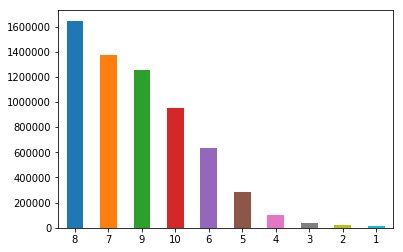

In [8]:
prob = ratings['rating'].value_counts()
prob.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

We see here that if people give any score to the anime, they tend to rate them pretty highly, average rating is almost 8! This probably means that animes with less score tend to be watched less and thus don't get same amount of ratings and vice versa.

In [9]:
# drop users with less than 100 rated shows
counts = ratings['user_id'].value_counts()
counts
counts[counts > 100]

42635    3747
53698    2905
57620    2689
59643    2632
51693    2621
45659    2462
7345     2429
12431    2348
65840    2215
22434    1991
51270    1835
65836    1825
49662    1815
30597    1801
11536    1793
23247    1781
40273    1780
30565    1777
13954    1744
59406    1723
9032     1702
49503    1681
28196    1672
51562    1671
23975    1637
54713    1615
27219    1587
1530     1584
23512    1579
67348    1573
         ... 
65350     101
43164     101
63476     101
59509     101
39328     101
25814     101
69456     101
41550     101
18707     101
52246     101
28904     101
30220     101
72023     101
72762     101
40821     101
21461     101
57241     101
325       101
46034     101
35721     101
21807     101
73028     101
31615     101
71733     101
72885     101
992       101
22820     101
2498      101
15065     101
16042     101
Name: user_id, Length: 19798, dtype: int64

In [10]:
ratings = ratings[ratings['user_id'].isin(counts[counts > 100].index)]

In [11]:
# Dropping animes that less than 1500 people have rated
counts = ratings['anime_id'].value_counts()
counts
counts[counts > 1500]

1535     14401
11757    13084
1575     12954
6547     12905
16498    12490
4224     12392
226      11980
2904     11930
5114     11232
8074     11203
2167     10809
121      10631
9253     10386
10620    10349
20       10227
9919     10054
2001     10040
849      10024
6746      9859
5081      9846
19815     9824
199       9786
11111     9619
4181      9233
9989      9122
3588      9102
356       8786
1195      8734
30        8710
15809     8708
         ...  
908       1551
1606      1550
21339     1547
7193      1546
443       1544
28617     1544
9834      1543
10357     1542
170       1539
18441     1539
6127      1534
4981      1534
26441     1533
16662     1532
452       1532
23421     1528
22043     1527
135       1525
32729     1523
17513     1518
16444     1514
713       1513
32438     1511
4015      1508
22        1506
6676      1504
10073     1503
16355     1503
793       1501
15        1501
Name: anime_id, Length: 913, dtype: int64

In [12]:
ratings = ratings[ratings['anime_id'].isin(counts[counts > 1500].index)]

In [13]:
ratings.describe()

,user_id,anime_id,rating
count,3.147604e+06,3.147604e+06,3.147604e+06
mean,3.647795e+04,9.419448e+03,7.904551e+00
std,2.095299e+04,8.706518e+03,1.487851e+00
min,5.000000e+00,1.000000e+00,1.000000e+00
25%,1.901100e+04,1.686000e+03,7.000000e+00
50%,3.580900e+04,7.088000e+03,8.000000e+00
75%,5.462100e+04,1.474100e+04,9.000000e+00
max,7.351500e+04,3.272900e+04,1.000000e+01


In [14]:
# pivot ratings into movie features
#df_anime_features = ratings.pivot(
#    index='anime_id',
#    columns='user_id',
#    values='rating'
#).fillna(0)
#
#anime_features = csr_matrix(df_anime_features.values)
#

In [15]:
shuffledratings = ratings.reindex(np.random.permutation(ratings.index))

In [16]:
group = np.array_split(shuffledratings, 3)

Here I have splitted the shuffled data in 3 pieces just to be able to get the algorithm work faster. Since I am using only bit over a million ratings, some shows might be skipped and accuracy is questionable at best.

In [17]:
group[1]

,user_id,anime_id,rating
2818346,26423,19111,10
6672417,61545,7193,8
1659928,16132,10568,8
492849,5016,1699,8
4357702,41171,67,5
415143,4274,762,6
3765443,35181,3785,7
3962721,37492,16668,10
550815,5492,6,6
6115799,57421,16498,7


In [18]:
lessratings = group[1]

In [19]:
# Construct reader
reader = Reader(rating_scale=(1, 10))

# Generate surprise Dataset
data = Dataset.load_from_df(lessratings[['user_id', 'anime_id', 'rating']], reader)

In [20]:
# Set all data as training set
trainset = data.build_full_trainset()

# Build and train an algorithm.

sim_options = {
               'user_based': True  # compute  similarities between items
}

algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [21]:
# Sample prediction
user_id = 4609
anime_id = 6351

pred = algo.predict(user_id, anime_id, verbose=True)
print('Name of the anime: ', animelist.name[animelist.anime_id[anime_id]])

user: 4609       item: 6351       r_ui = None   est = 7.68   {'actual_k': 40, 'was_impossible': False}
Name of the anime:  Mission-E


In [22]:
thisthing = ratings.loc[ratings['user_id'] == user_id]
thisthing.loc[thisthing['anime_id'] == anime_id]

,user_id,anime_id,rating


Just checking if the user actually has rated this anime

In [23]:
# Evaluate accuracy
# MAE = mean absolute error, RMSE = root mean squared error
cross_validate(algo, data, measures=['MAE', 'RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     0.9859  0.9854  0.9838  0.9850  0.0009  
RMSE (testset)    1.2892  1.2896  1.2862  1.2884  0.0015  
Fit time          88.94   93.23   90.98   91.05   1.75    
Test time         345.27  347.18  346.11  346.18  0.78    


{'test_mae': array([0.98591575, 0.98536635, 0.98375422]),
 'test_rmse': array([1.28920898, 1.28964572, 1.28624484]),
 'fit_time': (88.9447910785675, 93.22551202774048, 90.98223900794983),
 'test_time': (345.2680549621582, 347.17509841918945, 346.107488155365)}

In [24]:
# predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()
#predictions = algo.test(testset)

# Example:output
#print(predictions)

## Trying with a much smaller group

In [16]:
group2 = np.array_split(shuffledratings, 100)
lessratings2 = group2[1]

In [17]:
group2[1]

,user_id,anime_id,rating
2112511,20457,6573,5
2417725,23072,17513,3
4213184,39935,6325,7
6442272,59608,5030,8
2370406,22710,14345,8
6917866,64445,10793,8
6051608,56763,23079,3
6075797,56996,1210,8
2435802,23247,13655,8
5747868,53837,30,9


In [18]:
# Construct reader
reader2 = Reader(rating_scale=(1, 10))

# Generate surprise Dataset
data2 = Dataset.load_from_df(lessratings2[['user_id', 'anime_id', 'rating']], reader2)

In [19]:
# Set all data as training set
trainset2 = data2.build_full_trainset()

# Build and train an algorithm.

sim_options = {
               'user_based': True  # compute  similarities between items
}

algo2 = KNNBasic(sim_options=sim_options)
algo2.fit(trainset2)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [21]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset2 = trainset2.build_anti_testset()
predictions2 = algo2.test(testset2)

# Example:output
print(predictions2)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
# This block copied from Surprise documentation at
# http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions2, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

20457 [12355, 9969, 2904, 3588, 2167, 1604, 31181, 20785, 17729, 2963]
23072 [1571, 2904, 2236, 20785, 10456, 147, 10087, 6746, 578, 11285]
39935 [4181, 30276, 11757, 13535, 9969, 8516, 21881, 2787, 31043, 13667]
59608 [1575, 416, 2476, 11433, 5667, 18677, 6351, 11757, 9515, 11741]
22710 [4181, 12355, 9969, 20057, 11771, 22535, 1604, 9756, 31240, 2001]
64445 [7311, 30276, 1943, 3901, 2167, 934, 11933, 889, 12445, 7662]
56763 [11981, 199, 5114, 11061, 5680, 1571, 23289, 30276, 7338, 1564]
56996 [9969, 16498, 1, 3783, 6547, 6880, 15417, 11933, 1575, 1698]
23247 [4181, 6372, 10620, 14227, 11179, 5040, 2787, 801, 9756, 13667]
53837 [12355, 30276, 10620, 5300, 31043, 14075, 9617, 15417, 14713, 2104]
19978 [22729, 30276, 11741, 1536, 384, 9135, 387, 19815, 14075, 9617]
57580 [7311, 12355, 11757, 1943, 9471, 6421, 120, 14075, 2001, 22199]
24626 [6573, 20057, 2904, 10408, 356, 16662, 32, 6547, 8246, 9756]
14959 [5030, 9919, 1943, 20057, 22535, 9181, 9756, 15417, 849, 5205]
46313 [23289, 9969, 

17242 [21995, 12355, 30276, 1, 16355, 20057, 10408, 10863, 73, 20899]
29505 [13659, 4224, 1575, 9253, 227, 11737, 21843, 5678, 416, 357]
1026 [14227, 3588, 2966, 31181, 2963, 17265, 7674, 28497, 10087, 431]
26982 [6325, 10793, 16706, 8795, 21881, 2904, 28907, 195, 2001, 934]
14070 [4181, 11757, 27899, 5081, 31240, 11843, 227, 20583, 31859, 10162]
24256 [30, 5680, 1943, 226, 3572, 5681, 11771, 4898, 5081, 2236]
29706 [30, 4181, 12355, 2034, 30205, 902, 2966, 5958, 16009, 15315]
67775 [4181, 12355, 9969, 8915, 6880, 31240, 2001, 2236, 552, 16934]
29635 [28171, 1604, 31240, 16918, 1686, 15335, 6675, 1118, 263, 28223]
8221 [30, 15699, 4224, 9756, 2963, 121, 28297, 431, 6213, 13663]
60107 [6547, 9617, 4726, 5277, 889, 5114, 1686, 9989, 11737, 7590]
3412 [2034, 10897, 11179, 16005, 16524, 6547, 31043, 9181, 4726, 20785]
71359 [27899, 223, 16706, 16498, 4437, 28171, 19815, 6547, 11981, 530]
51519 [3588, 2167, 6772, 31181, 4726, 15417, 2963, 5114, 8769, 17265]
56512 [4181, 9919, 71, 8795, 2904

14142 [443, 10897, 16005, 16524, 6547, 31043, 9181, 1575, 31704, 9253]
8755 [6573, 30, 5680, 22729, 2993, 16498, 1, 16355, 11771, 9756]
47143 [11757, 1536, 11771, 16662, 1117, 1604, 31181, 13667, 270, 15417]
27228 [12355, 29803, 9969, 6594, 3783, 10620, 13667, 4725, 4565, 10165]
21436 [4181, 7338, 11741, 15315, 199, 11061, 10067, 227, 9989, 8676]
47509 [4181, 20, 27899, 16498, 11111, 6547, 13667, 20785, 5114, 431]
30565 [4224, 22199, 5114, 25159, 11319, 11061, 8460, 1840, 25157, 1535]
56825 [10793, 28223, 889, 762, 10087, 1535, 329, 4835, 31637, 31043]
57680 [245, 18115, 18397, 19815, 196, 5081, 431, 13759, 6702, 14345]
47612 [16035, 2167, 1604, 241, 2001, 2236, 30240, 164, 245, 30296]
5899 [11757, 9515, 10408, 28171, 356, 1117, 5205, 4382, 164, 15335]
26976 [5680, 13535, 2904, 16662, 1530, 10863, 45, 170, 1575, 12445]
7783 [11757, 10620, 4214, 28171, 5114, 5205, 72, 3784, 846, 15451]
65381 [6573, 5680, 3783, 11111, 19815, 11933, 12365, 25183, 20583, 9919]
10956 [21995, 71, 9969, 16762

10426 [4181, 5040, 4214, 28171, 6702, 22535, 8246, 13367, 11061, 10161]
56846 [1827, 16498, 10030, 33, 12113, 12355, 5081, 849, 12365, 6351]
8318 [9969, 2167, 20785, 13125, 16067, 6213, 16011, 387, 4181, 16706]
51993 [223, 5040, 2167, 16742, 356, 4224, 120, 401, 889, 5114]
13779 [30276, 801, 10165, 11577, 12445, 27821, 3572, 13663, 740, 877]
14577 [4181, 12355, 9969, 3783, 15699, 6702, 32, 32282, 22147, 4752]
22758 [11597, 6033, 28171, 32, 1530, 10396, 7791, 9074, 23283, 48]
54294 [120, 22147, 849, 1575, 8408, 4280, 14397, 6211, 132, 5680]
6800 [30, 3457, 20, 6594, 11741, 1536, 11111, 355, 387, 6702]
50431 [4181, 7338, 16498, 3588, 5300, 15315, 199, 20507, 11061, 12291]
57393 [199, 1575, 9253, 1691, 227, 323, 1535, 2251, 13125, 47]
28505 [9135, 32, 801, 4224, 15315, 5114, 9253, 226, 164, 9989]
39159 [4181, 71, 877, 28623, 31043, 8129, 2593, 849, 225, 9253]
11097 [28171, 813, 1575, 330, 18897, 3784, 25157, 19163, 22877, 1559]
26523 [29803, 14227, 11741, 27631, 30831, 5081, 1195, 813, 29

49137 [4181, 5680, 12355, 1943, 2904, 384, 5300, 1604, 31043, 4224]
31073 [4181, 1, 10620, 5690, 2904, 28171, 813, 1575, 164, 14713]
29210 [5030, 1210, 30, 4181, 28623, 902, 11741, 6033, 19815, 5300]
22886 [22729, 16706, 9969, 15809, 11741, 2167, 10408, 10863, 120, 199]
41703 [13655, 7311, 223, 29803, 1827, 11111, 6772, 10408, 11771, 30831]
51106 [4181, 3783, 9756, 270, 10495, 19, 16067, 3091, 267, 14289]
22987 [10165, 5114, 20021, 416, 4901, 249, 7817, 32729, 9982, 12531]
10679 [5040, 384, 28171, 6702, 28999, 4726, 813, 8425, 11061, 6512]
57219 [5680, 9135, 28171, 371, 31043, 15315, 30831, 22265, 14749, 30240]
26743 [16498, 3588, 9135, 387, 15315, 813, 849, 5114, 1575, 523]
26162 [6573, 2034, 877, 30205, 28623, 20057, 11111, 6033, 19815, 6547]
26036 [2904, 10408, 356, 6547, 15315, 28223, 11061, 8841, 1887, 710]
379 [5040, 199, 11577, 11759, 7674, 9989, 31964, 6746, 431, 5]
49803 [16706, 1827, 11741, 28907, 6702, 22535, 21603, 1575, 11759, 17895]
73395 [4181, 30205, 28623, 1536, 11111,

792 [9969, 19815, 9041, 22199, 15417, 5114, 1575, 5678, 28297, 6746]
61995 [13655, 4181, 30276, 223, 443, 10897, 21881, 16005, 2787, 28171]
66643 [4181, 29803, 8795, 934, 10165, 1575, 23755, 12477, 19163, 513]
55206 [30, 4181, 2034, 30205, 2926, 16742, 22535, 1117, 73, 8074]
45098 [71, 16706, 21881, 384, 4224, 849, 245, 24415, 2952, 10049]
45831 [5030, 2034, 30205, 11741, 2904, 5300, 1604, 4224, 256, 9756]
22819 [30276, 3783, 10800, 3588, 2167, 73, 846, 2025, 457, 205]
8921 [6573, 12355, 317, 16498, 14227, 4214, 11771, 6702, 199, 5205]
12593 [4181, 2034, 30205, 28623, 1536, 11111, 6033, 19815, 6547, 10863]
261 [30276, 21881, 31043, 22319, 1689, 237, 23273, 18441, 481, 857]
43599 [6573, 2926, 3783, 16742, 19815, 22535, 1117, 11933, 1535, 13357]
47755 [16498, 14227, 2167, 384, 5081, 416, 9790, 4789, 22297, 177]
15933 [11597, 7311, 30276, 29803, 9969, 6772, 15417, 17265, 2025, 28297]
65752 [4752, 79, 9790, 1482, 18679, 2001, 68, 7647, 9989, 6347]
21045 [11757, 15809, 9756, 2001, 8425, 277

52307 [21995, 877, 4224, 3087, 121, 11577, 4081, 1604, 1530, 1195]
3584 [18679, 1, 15699, 10790, 356, 32, 30831, 120, 8129, 31240]
66200 [6594, 30205, 11111, 18671, 530, 849, 17895, 72, 4059, 16]
58170 [30276, 1943, 6594, 3901, 2167, 11933, 889, 7662, 1686, 6746]
57541 [13655, 30, 4181, 16035, 1943, 6594, 2904, 3588, 27631, 2787]
58839 [30, 4181, 29803, 16498, 3783, 5040, 2167, 19815, 32, 7791]
54847 [2167, 6772, 199, 14075, 2001, 4726, 15417, 5114, 8769, 164]
36649 [13655, 223, 29803, 30205, 28623, 20057, 6033, 2787, 790, 10863]
27016 [7311, 9919, 3299, 317, 14741, 1530, 9041, 45, 15417, 1575]
41432 [1482, 18679, 1, 199, 30240, 6811, 15689, 3784, 10087, 1535]
61843 [7311, 14075, 2001, 4726, 849, 5114, 121, 10080, 226, 8074]
40483 [16524, 1604, 8425, 72, 15225, 13601, 3358, 11617, 513, 7769]
45408 [30276, 223, 2787, 32, 31043, 9041, 14075, 15583, 15417, 10165]
45457 [7311, 71, 384, 6702, 801, 4224, 2001, 5114, 5112, 9253]
66355 [27899, 29803, 16498, 16742, 28171, 1604, 10863, 5081, 200

49142 [30, 2034, 1, 30205, 28623, 2167, 10863, 73, 2001, 10165]
6920 [1210, 4181, 71, 877, 16498, 28623, 15699, 3588, 5300, 31043]
25632 [21995, 12355, 30276, 2581, 11741, 11771, 7791, 401, 2001, 2236]
14971 [2904, 387, 14513, 2593, 1575, 14713, 4059, 23283, 15437, 10030]
64766 [22535, 120, 22147, 849, 10165, 15051, 4280, 14397, 6211, 33]
6929 [30, 20, 11757, 29803, 2904, 6547, 13759, 26055, 17074, 4181]
20830 [6594, 2904, 4726, 5114, 1559, 3230, 2025, 6746, 6922, 134]
19179 [4181, 30276, 9969, 1827, 6594, 4437, 6772, 3712, 790, 9253]
5669 [16498, 1536, 2904, 28171, 20785, 2593, 5205, 23755, 4059, 4654]
72468 [10793, 30, 223, 11741, 11771, 5958, 11981, 9181, 32282, 15417]
54230 [30, 29803, 6547, 199, 45, 121, 11843, 147, 846, 32182]
27736 [10793, 4155, 11887, 10379, 18195, 587, 11757, 21431, 6702, 10163]
22740 [30, 16498, 2001, 270, 10165, 11759, 10067, 79, 9790, 18245]
44625 [4181, 21431, 2904, 387, 813, 849, 10165, 10495, 523, 6746]
65978 [9969, 6594, 2167, 6772, 2966, 5958, 356, 371

8024 [30276, 2034, 1827, 45, 16918, 4382, 9253, 1698, 323, 13601]
73507 [4565, 11737, 20689, 2026, 7817, 18677, 6211, 9936, 33, 1195]
53370 [1, 3783, 21881, 2904, 199, 11933, 523, 8408, 57, 11617]
23458 [5680, 1, 9471, 3783, 9135, 28171, 3712, 6421, 371, 22265]
54560 [4181, 1575, 11319, 23673, 268, 18897, 2167, 6702, 28999, 31043]
18344 [5030, 30, 7088, 2034, 15809, 30205, 11741, 2904, 4224, 256]
13202 [1827, 28121, 10080, 11061, 11737, 7590, 1535, 2251, 13357, 457]
39080 [30, 2034, 30205, 28623, 11741, 13659, 73, 2001, 1575, 9253]
71438 [4181, 11757, 27899, 5081, 31240, 11843, 227, 20583, 31859, 10162]
29136 [9969, 21431, 3901, 3588, 2966, 387, 5114, 121, 11577, 7674]
60989 [5680, 7311, 30276, 10800, 1604, 10863, 10396, 195, 2001, 270]
33931 [20, 18857, 6594, 10620, 20057, 3712, 1530, 30240, 27821, 164]
3543 [13655, 4181, 30276, 7338, 223, 14741, 16498, 20057, 5040, 2904]
19354 [9969, 2904, 11499, 31043, 121, 11577, 5112, 9253, 7674, 5630]
21603 [7311, 71, 14227, 20057, 4214, 27631, 2

21775 [6372, 9919, 16706, 2904, 14513, 9617, 813, 20899, 164, 528]
28759 [30307, 6702, 30831, 120, 8246, 8129, 31240, 10495, 1142, 5341]
38966 [22729, 1, 3901, 11771, 19815, 28999, 10863, 1575, 5205, 20899]
65737 [6573, 30276, 2904, 10408, 356, 16662, 6547, 9617, 17265, 4081]
12671 [4181, 877, 9969, 16498, 2904, 8915, 6880, 4155, 5114, 6682]
42570 [4181, 30276, 443, 5040, 21603, 985, 5114, 4059, 2251, 57]
68890 [11597, 21995, 29803, 8795, 16498, 902, 2581, 4214, 9135, 2966]
68617 [2034, 6702, 985, 2001, 849, 5114, 9989, 390, 2759, 777]
26821 [30, 20, 29803, 9969, 6594, 15699, 2904, 2966, 20541, 6547]
61833 [11597, 21995, 317, 8795, 5040, 2966, 19815, 11981, 11577, 11759]
12761 [71, 2904, 6033, 15315, 1575, 9253, 226, 9834, 12365, 7592]
67832 [30276, 5114, 457, 205, 2759, 1719, 9734, 4654, 7338, 11757]
41758 [71, 902, 4214, 6033, 16009, 801, 9181, 14967, 28617, 6773]
24882 [4181, 1943, 15809, 1195, 813, 2025, 4472, 467, 1689, 30503]
58192 [30205, 16009, 801, 28617, 10568, 10719, 3731, 1

793 [21995, 71, 9969, 16762, 9135, 6547, 4224, 30831, 4898, 14749]
64173 [28171, 2001, 45, 1562, 467, 14397, 934, 6811, 57, 44]
28001 [9919, 20057, 11771, 22535, 10863, 9756, 849, 9253, 23755, 12365]
22491 [2581, 387, 120, 32282, 249, 5258, 5525, 12115, 3782, 11979]
29390 [1, 32, 416, 2904, 2966, 2001, 1575, 457, 532, 2605]
47466 [1210, 9969, 1482, 16498, 2167, 13659, 11771, 801, 6880, 9041]
28566 [9919, 16662, 9041, 199, 11843, 9253, 15687, 513, 2508, 19363]
59723 [5680, 10800, 3784, 4059, 457, 1723, 376, 2476, 264, 986]
26568 [877, 10863, 813, 5112, 9253, 10456, 6211, 4181, 15809, 30307]
27718 [4181, 16706, 14741, 16498, 2904, 32, 2472, 9756, 10495, 20899]
30174 [4181, 16706, 14741, 16498, 32, 9756, 20899, 9253, 16934, 9989]
20811 [10793, 21881, 32, 1604, 14513, 9756, 6773, 2025, 28249, 14813]
29093 [4181, 1943, 15809, 1195, 813, 2025, 4472, 467, 1689, 30503]
13934 [30276, 22199, 5114, 512, 31859, 3588, 19815, 16009, 23755, 1535]
762 [30, 3588, 31181, 2963, 17265, 28497, 431, 5681, 5

5740 [23289, 1827, 121, 16353, 25879, 3342, 11741, 9181, 50, 6682]
24571 [6573, 19815, 256, 790, 1698, 164, 8408, 20583, 1689, 205]
44416 [5030, 15809, 2904, 6772, 16524, 22535, 9181, 20507, 9756, 73]
40959 [6573, 4181, 12355, 20, 71, 2904, 32, 5300, 31181, 1530]
59581 [317, 29803, 1, 9471, 2167, 9135, 6421, 10863, 120, 2001]
51 [16035, 356, 1686, 245, 18245, 481, 12355, 97, 6547, 31043]
39808 [9969, 16498, 3901, 2904, 28999, 1575, 9989, 26243, 16, 232]
52772 [30, 4181, 22729, 9135, 11981, 8246, 813, 226, 12291, 59]
29665 [1604, 120, 205, 4107, 550, 877, 4752, 25835, 9253, 6811]
52733 [11597, 21881, 1530, 7791, 9074, 23283, 48, 2890, 44, 1559]
22529 [7311, 7088, 849, 5114, 1575, 5630, 10030, 23847, 1887, 177]
37238 [4181, 3457, 30276, 8516, 356, 199, 14075, 1195, 9617, 15417]
62421 [7311, 12355, 29803, 14227, 11741, 27631, 1117, 4224, 30831, 5081]
45732 [877, 1, 2581, 2904, 6682, 10080, 18897, 26243, 2927, 6201]
46091 [20, 27899, 71, 16706, 877, 9969, 18679, 1, 4214, 10408]
571 [21995,

38592 [7711, 10067, 4081, 918, 19363, 5114, 1, 4224, 6573, 11111]
24442 [897, 6547, 15315, 32282, 31240, 226, 10456, 9989, 1840, 21659]
28144 [29803, 1943, 16498, 2926, 2167, 6702, 10863, 4726, 10165, 9253]
59870 [5680, 30276, 20057, 387, 6547, 11981, 8246, 2963, 5114, 121]
65284 [16498, 45, 15417, 121, 11843, 6030, 147, 846, 32182, 2251]
35157 [4181, 12355, 22729, 9919, 30276, 29803, 5040, 19815, 356, 31240]
56463 [10620, 20787, 2904, 813, 889, 5114, 11577, 523, 8074, 8861]
68119 [4181, 9515, 32, 20785, 5079, 15451, 6, 1689, 4063, 5525]
26965 [11597, 30276, 223, 71, 20541, 17265, 18897, 20031, 4789, 5667]
43641 [30276, 3783, 10800, 3588, 2167, 73, 846, 2025, 457, 205]
42348 [6573, 22729, 23289, 877, 15809, 10863, 4155, 2963, 5114, 9253]
25996 [21881, 6547, 9756, 22147, 4752, 5205, 23755, 7674, 1840, 15451]
28296 [6325, 4181, 7338, 14741, 9969, 21881, 28907, 32, 15315, 530]
31090 [30, 30276, 11771, 790, 9756, 73, 270, 20785, 5114, 11061]
4404 [6573, 5680, 12355, 22729, 29803, 1, 15699,

49833 [6573, 19815, 256, 790, 1698, 164, 8408, 20583, 1689, 205]
6112 [30, 3457, 20, 6594, 11741, 1536, 11111, 355, 387, 6702]
19931 [4181, 20, 27899, 16498, 11111, 6547, 13667, 20785, 5114, 431]
37233 [2001, 23755, 12113, 9736, 20853, 6773, 9367, 237, 12967, 13759]
71829 [30276, 1943, 6594, 3901, 2167, 11933, 889, 7662, 1686, 6746]
58180 [2904, 11061, 23283, 12859, 17074, 1210, 21995, 20, 9919, 29803]
15272 [19815, 32, 15315, 2001, 1575, 24833, 25157, 1535, 10030, 6746]
36274 [6573, 2904, 10408, 2966, 6547, 9617, 5114, 227, 4081, 25183]
71537 [30, 3457, 6594, 11741, 1536, 355, 28171, 6702, 32, 6547]
23218 [10793, 223, 16498, 21881, 10790, 9756, 2001, 270, 10165, 889]
26072 [9756, 416, 79, 918, 60, 237, 6114, 16011, 2961, 4472]
16199 [5030, 223, 15809, 11433, 834, 18677, 18195, 11757, 9181, 195]
70842 [9989, 1889, 30, 19815, 22147, 2001, 5114, 11737, 1689, 12859]
64624 [30205, 14227, 32, 15315, 11061, 323, 25157, 24415, 10161, 10030]
26909 [18857, 30276, 29803, 1482, 16498, 1, 2167, 37

25629 [11597, 7311, 23289, 2167, 3712, 20541, 6547, 1604, 14075, 5081]
33557 [8516, 31043, 135, 2418, 4181, 11771, 8675, 28223, 31704, 17265]
52482 [30276, 7338, 31043, 17729, 6773, 7674, 245, 9989, 430, 6746]
45078 [30, 4181, 9969, 16498, 3901, 11741, 2904, 3588, 27631, 28907]
39335 [6573, 27899, 223, 16706, 4437, 11741, 2966, 356, 801, 30831]
66554 [11597, 30276, 11757, 1827, 14227, 2966, 22535, 28223, 15051, 5630]
19454 [16035, 356, 1686, 245, 18245, 481, 12355, 97, 6547, 31043]
33147 [30276, 1943, 6594, 3901, 10863, 11933, 1562, 7662, 8408, 1686]
25223 [4181, 31043, 28223, 24415, 21033, 2605, 9041, 164, 227, 6]
27754 [5680, 30276, 223, 1943, 97, 1827, 3901, 2167, 11933, 7662]
361 [317, 195, 13667, 11933, 16067, 740, 14289, 10495, 330, 12365]
18235 [11499, 14967, 134, 10379, 22, 2966, 6547, 4224, 10863, 339]
63240 [30276, 5682, 4725, 889, 9253, 18897, 846, 2025, 18115, 28249]
57852 [6573, 19815, 256, 790, 1698, 164, 8408, 20583, 1689, 205]
3621 [8630, 2926, 16742, 22535, 1117, 1535,

30568 [7193, 790, 6023, 14813, 329, 896, 543, 6676, 11979, 12113]
60522 [223, 21881, 2966, 898, 5958, 10863, 10165, 1575, 1562, 8408]
33226 [147, 6, 12115, 1818, 20, 801, 202, 101, 6007, 387]
30552 [18857, 11757, 16498, 1, 28623, 5040, 9587, 2787, 11771, 2001]
64785 [6573, 5680, 22729, 1, 11771, 20899, 11061, 2251, 18507, 205]
34246 [1482, 1536, 6772, 6702, 4224, 199, 20507, 14075, 2001, 4726]
49231 [19815, 10863, 5205, 528, 268, 13759, 2026, 18679, 3783, 356]
71999 [1, 5690, 1536, 31181, 7791, 15417, 813, 16049, 8425, 11061]
25054 [3588, 10408, 1530, 10863, 22147, 1575, 20899, 11843, 9989, 2251]
63764 [21995, 22729, 11757, 13535, 26349, 3588, 355, 10408, 935, 31043]
7351 [9919, 2904, 9617, 813, 164, 901, 528, 18507, 5118, 7]
50483 [30276, 2034, 1827, 45, 16918, 4382, 9253, 1698, 323, 13601]
45483 [1210, 30, 3901, 11981, 849, 5114, 1575, 11577, 10080, 15689]
50771 [4181, 5680, 7311, 18857, 3783, 11741, 790, 6880, 120, 32282]
51470 [1210, 1536, 192, 5682, 32438, 121, 2104, 2251, 467, 44

18523 [355, 121, 6030, 457, 30296, 28701, 25681, 2904, 3588, 6702]
41913 [1, 28623, 5040, 2787, 10863, 22199, 10165, 5114, 1575, 487]
3346 [11597, 7311, 11757, 1, 28623, 5040, 1536, 2787, 20541, 22535]
68182 [29803, 16498, 10620, 2167, 31181, 889, 227, 65, 1535, 4081]
56002 [22729, 23289, 15809, 10863, 889, 5114, 1575, 9253, 164, 9989]
52230 [21995, 20, 18857, 6594, 10620, 20057, 3712, 4224, 27821, 245]
37377 [13535, 15315, 9181, 5081, 22147, 11577, 9367, 9253, 16067, 18295]
24544 [4181, 12355, 16706, 2904, 3588, 1604, 17729, 11061, 10067, 19]
60031 [330, 3784, 2025, 1559, 13663, 6351, 29803, 1943, 16498, 3783]
30333 [29803, 9135, 2966, 19815, 14967, 31240, 28121, 552, 9989, 21405]
8969 [30, 4181, 2034, 30205, 28623, 73, 8074, 9314, 227, 2952]
39305 [12355, 10408, 356, 6547, 7791, 20785, 9253, 22135, 9074, 4472]
67305 [12355, 223, 11981, 4901, 1210, 2403, 26349, 16524, 22147, 50]
39343 [12355, 2581, 11741, 1117, 5081, 2236, 10165, 205, 14811, 985]
17982 [22535, 270, 10067, 19, 2759, 13

10229 [7193, 16498, 1698, 4472, 47, 777, 121, 2476, 329, 11757]
69250 [7674, 245, 21881, 45, 4155, 29095, 164, 263, 1482, 10790]
11724 [10793, 4155, 11887, 10379, 18195, 587, 11757, 21431, 6702, 10163]
3315 [199, 5081, 469, 8086, 443, 1482, 16498, 11111, 1575, 11577]
26213 [16706, 7791, 199, 3784, 14719, 14527, 5114, 3457, 2904, 387]
18621 [4181, 12355, 20, 71, 2904, 32, 14075, 4725, 15417, 5114]
63540 [18857, 7088, 27899, 2904, 10863, 9041, 7791, 11933, 10495, 8074]
45998 [9919, 2904, 28223, 9617, 813, 27821, 164, 1519, 528, 18507]
20327 [4181, 199, 14075, 2593, 32438, 1691, 43, 6862, 7769, 16011]
4237 [11757, 27899, 5081, 31240, 11843, 227, 20583, 31859, 10162, 4181]
41492 [18857, 7088, 27899, 2904, 10863, 9041, 7791, 11933, 10495, 8074]
64199 [5114, 7088, 2904, 28907, 28171, 24833, 1535, 32182, 23283, 27833]
21061 [1827, 16498, 6880, 1575, 1698, 47, 18245, 14719, 33, 14345]
32703 [10793, 21881, 32, 1604, 14513, 9756, 6773, 2025, 28249, 14813]
17514 [30276, 28623, 2581, 5040, 9253, 9

In [ ]:
# Evaluate accuracy
# MAE = mean absolute error, RMSE = root mean squared error
cross_validate(algo2, data2, measures=['MAE', 'RMSE'], cv=3, verbose=True)

# Conclusions

My computer at least is very much struggling when using KNN algorithm even when I have tried to make dataset much smaller and more meaningful. I did run into memory issues multiple times, and even after some trimming using almost all of my available RAM to run algorithm. Runtimes could be anything and I had to kill whole jupyter notebook multiple times just to be able to continue tinkering.

For ratings dataset I first removed all the watched, but not rated shows and after that tried to limit the list by how many users had rated any shows. After that I removed shows which had only small amounts of ratings. Lastly I just randomized order of the data and cut it into pieces and tried running with smaller dataset. Even then predicting top tens for that many users was out of reach if I didn't cut dataset to even smaller pieces.

